# Importing libraries

In [174]:
import pandas as pd
import geopandas as gp
from shapely import wkt
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import duckdb as db

# Connecting to duckdb database
* Install and load **SPATIAL** extension to display **gps table**
* Showing all tables


In [130]:
con = db.connect("../cyberdeck.db") 
con.install_extension("spatial")
con.load_extension("spatial")

In [131]:
con.sql("show tables;")

┌────────────┐
│    name    │
│  varchar   │
├────────────┤
│ barometric │
│ cpu        │
│ device     │
│ gps        │
└────────────┘

In [132]:
con.sql("select * from device;")

┌───────────┬─────────────┬──────────────┐
│ device_id │ device_name │ date_created │
│   int8    │   varchar   │  timestamp   │
├───────────┴─────────────┴──────────────┤
│                 0 rows                 │
└────────────────────────────────────────┘

In [133]:
con.sql("select * from barometric;")

┌───────────┬───────────────┬────────────────────┬────────────────────┐
│ device_id │ temperature_c │    pressure_hpa    │     altitude_m     │
│   int8    │    double     │       double       │       double       │
├───────────┼───────────────┼────────────────────┼────────────────────┤
│      NULL │ 27.8455078125 │ 1010.9668709992525 │  50.27470127404733 │
│      NULL │ 27.8748046875 │  1010.933108571557 │ 50.247412445274065 │
│      NULL │ 27.9412109375 │ 1010.9464616310931 │  50.19226427378505 │
│      NULL │  27.955859375 │ 1010.9619420751385 │   50.2097829196821 │
│      NULL │   27.96328125 │ 1010.9355321054054 │  50.33753813295399 │
│      NULL │   27.87734375 │ 1010.9497155967625 │  50.05872910177986 │
│      NULL │ 27.8724609375 │ 1010.9563171747362 │  50.26116973303033 │
│      NULL │  27.884765625 │ 1010.9402827312987 │  50.30462319193966 │
│      NULL │  27.867578125 │ 1010.9448671314253 │ 50.423832693252834 │
│      NULL │ 27.8552734375 │ 1010.9290154550876 │  50.323619471

In [134]:
con.sql("select * from cpu;")

┌───────────┬──────────┬─────────────────┬──────────────────────┐
│ device_id │ cpu_load │ memory_usage_mb │ memory_usage_percent │
│   int8    │  double  │     double      │       varchar        │
├───────────┼──────────┼─────────────────┼──────────────────────┤
│      NULL │     69.0 │            0.22 │ 420/1900             │
│      NULL │     67.0 │            0.28 │ 422/1900             │
│      NULL │     70.0 │            0.28 │ 424/1900             │
│      NULL │     67.0 │            0.34 │ 425/1900             │
│      NULL │     68.0 │            0.34 │ 427/1900             │
│      NULL │     67.0 │            0.52 │ 427/1900             │
│      NULL │     67.0 │            0.48 │ 426/1900             │
│      NULL │     68.0 │            0.48 │ 426/1900             │
│      NULL │     67.0 │            0.44 │ 425/1900             │
│      NULL │     67.0 │            0.44 │ 426/1900             │
│        ·  │       ·  │              ·  │    ·                 │
│        ·

In [135]:
con.sql("select * from gps;")

┌───────────┬─────────────────────┬───────────┬─────────────────────┬──────────┬────────────────────┬──────────────────┐
│ device_id │      datetime       │ longitude │ longitude_direction │ latitude │ latitude_direction │ lon_lat_geometry │
│   int8    │      timestamp      │  double   │       varchar       │  double  │      varchar       │     geometry     │
├───────────┼─────────────────────┼───────────┼─────────────────────┼──────────┼────────────────────┼──────────────────┤
│      NULL │ 2025-09-12 00:47:37 │       0.0 │ NULL                │      0.0 │ NULL               │ POINT (0 0)      │
│      NULL │ 2025-09-12 00:47:53 │       0.0 │ NULL                │      0.0 │ NULL               │ POINT (0 0)      │
│      NULL │ 2025-09-12 00:48:05 │       0.0 │ NULL                │      0.0 │ NULL               │ POINT (0 0)      │
│      NULL │ 2025-09-12 00:48:23 │       0.0 │ NULL                │      0.0 │ NULL               │ POINT (0 0)      │
│      NULL │ 2025-09-12 00:48:3

# Converting **gps** table to **Dataframe**
* Convert **lon_lat_geometry** to **Geopandas Dataframe**
* Filter **non zero** lat/lon coordinates

In [136]:
gps = con.sql("select datetime, longitude, longitude_direction, latitude, latitude_direction, ST_AsText(lon_lat_geometry) as lon_lat_geometry from gps;")
df_gps = gps.df()

In [137]:
print(type(df_gps))
df_gps["lon_lat_geometry"]

<class 'pandas.core.frame.DataFrame'>


0      POINT (0 0)
1      POINT (0 0)
2      POINT (0 0)
3      POINT (0 0)
4      POINT (0 0)
          ...     
675    POINT (0 0)
676    POINT (0 0)
677    POINT (0 0)
678    POINT (0 0)
679    POINT (0 0)
Name: lon_lat_geometry, Length: 680, dtype: object

In [138]:
#df_gps["lon_lat_geometry"] = df_gps["lon_lat_geometry"].apply(wkt.loads)
df_gps["lon_lat_geometry"] = gp.GeoSeries.from_wkt(df_gps["lon_lat_geometry"])
gdf_gps = gp.GeoDataFrame(df_gps, geometry="lon_lat_geometry", crs="EPSG:4326")
gdf_gps

,datetime,longitude,longitude_direction,latitude,latitude_direction,lon_lat_geometry
0,2025-09-12 00:47:37,0.0,None,0.0,None,POINT (0 0)
1,2025-09-12 00:47:53,0.0,None,0.0,None,POINT (0 0)
2,2025-09-12 00:48:05,0.0,None,0.0,None,POINT (0 0)
3,2025-09-12 00:48:23,0.0,None,0.0,None,POINT (0 0)
4,2025-09-12 00:48:37,0.0,None,0.0,None,POINT (0 0)
...,...,...,...,...,...,...
675,2025-09-13 21:57:04,0.0,None,0.0,None,POINT (0 0)
676,2025-09-13 21:57:20,0.0,None,0.0,None,POINT (0 0)
677,2025-09-13 21:57:41,0.0,None,0.0,None,POINT (0 0)
678,2025-09-13 21:58:08,0.0,None,0.0,None,POINT (0 0)


In [139]:
# confirming CRS (coordinate reference system) values
# and dataframe values
print(gdf_gps.crs)
type(gdf_gps)

EPSG:4326


geopandas.geodataframe.GeoDataFrame

In [140]:
# filtering non zero values to plot onto map
# putting that on new geopandas dataframe
condition = (gdf_gps["longitude"] != 0) & (gdf_gps["latitude"] != 0)
non_zero = gdf_gps[condition]
non_zero

,datetime,longitude,longitude_direction,latitude,latitude_direction,lon_lat_geometry
320,2025-09-13 16:17:40,-79.514283,W,43.671298,N,POINT (-79.51428 43.6713)
321,2025-09-13 16:18:02,-79.514282,W,43.671303,N,POINT (-79.51428 43.6713)
322,2025-09-13 16:18:26,-79.514287,W,43.671307,N,POINT (-79.51429 43.67131)
323,2025-09-13 16:18:46,-79.514287,W,43.671307,N,POINT (-79.51429 43.67131)
324,2025-09-13 16:19:08,-79.514277,W,43.671308,N,POINT (-79.51428 43.67131)
...,...,...,...,...,...,...
475,2025-09-13 17:44:15,-79.505120,W,43.708012,N,POINT (-79.50512 43.70801)
476,2025-09-13 17:44:30,-79.505135,W,43.708102,N,POINT (-79.50514 43.7081)
477,2025-09-13 17:44:57,-79.505153,W,43.708195,N,POINT (-79.50515 43.7082)
478,2025-09-13 17:45:08,-79.505172,W,43.708288,N,POINT (-79.50517 43.70829)


In [141]:
gps_map = gp.read_file("./parks-wgs84")
print(gps_map.crs)
gps_map

GEOGCS["WGS 84",DATUM["World Geodetic System 1984 [EPSG ID 6326]",SPHEROID["WGS 84 [EPSG ID 7030]",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Decimal_Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]


,OBJECTID,GEO_ID,TYPE_DESC,SCODE_NAME,LCODE_NAME,NAME,geometry
0,180,180.0,CGSP,None,3017,CITY WIDE OPEN SPACE,"POLYGON ((-79.22672 43.80698, -79.2266 43.8069..."
1,193,193.0,CGSP,None,3050,PUBLIC ACCESS PROPERTY,"POLYGON ((-79.20123 43.80354, -79.20116 43.803..."
2,325,325.0,CGSP,None,3017,CITY WIDE OPEN SPACE,"POLYGON ((-79.2417 43.7796, -79.24294 43.77826..."
3,327,327.0,CGSP,None,3024,EAST HIGHLAND CREEK WATERCOURSE,"POLYGON ((-79.23614 43.77942, -79.23556 43.779..."
4,328,328.0,CGSP,None,3017,CITY WIDE OPEN SPACE,"POLYGON ((-79.41225 43.77916, -79.41222 43.779..."
...,...,...,...,...,...,...,...
3269,4306630,109.0,CGSP,None,3026,CITY WIDE OPEN SPACE,"POLYGON ((-79.16681 43.82439, -79.1654 43.8231..."
3270,4306631,117.0,CGSP,None,3026,CITY WIDE OPEN SPACE,"POLYGON ((-79.16478 43.82095, -79.16521 43.820..."
3271,4306633,196.0,CGSP,None,3026,CITY WIDE OPEN SPACE,"POLYGON ((-79.15168 43.80284, -79.1516 43.8026..."
3272,4306634,579.0,CGSP,None,3026,CITY WIDE OPEN SPACE,"POLYGON ((-79.25633 43.71383, -79.2567 43.7132..."


In [142]:
james_garden = gps_map[gps_map["NAME"] == "JAMES GARDENS"]
james_garden

,OBJECTID,GEO_ID,TYPE_DESC,SCODE_NAME,LCODE_NAME,NAME,geometry
1908,4305157,539.0,CGSP,539,539,JAMES GARDENS,"POLYGON ((-79.51514 43.67167, -79.51506 43.671..."


## Plotting coordinates 

## Option 1: matplotlib
* More specific onto regions 

-79.51746115 43.66970926 -79.51305667 43.67187585


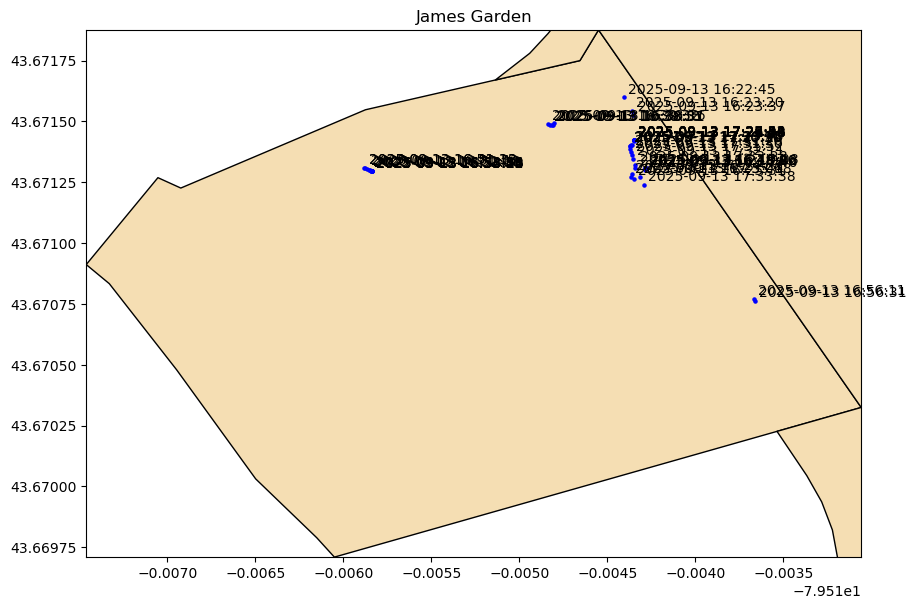

In [143]:
# region boundary 
minx, miny, maxx, maxy = james_garden.total_bounds
print(minx, miny, maxx, maxy)

fig,ax = plt.subplots(figsize=(10,10))
ax.set_title("James Garden")

# zooming into region
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

gps_map.plot(ax=ax, facecolor="wheat", edgecolor="black", linewidth=1)
non_zero.plot(ax=ax, color="blue", markersize=5)

for idx, row in gdf_gps.iterrows():
    ax.annotate(text=row["datetime"],
                xy=(row.longitude,row.latitude),
                xytext=(3,3),
                textcoords="offset points",
                fontsize=10,
                color="black"
               )


## Option 2: Geopandas Explore
* Interactive and automarks coordinates
* For overall views

In [144]:
non_zero.explore(zoom_start=13)

# Converting barometric to **Dataframe** 
* extracting datetime from gps column to plot (NEXT TIME ADD DATETIME COLUMN TO CSV)

In [145]:
barometric = con.sql("select temperature_c, pressure_hpa, altitude_m from barometric;")
df_barometric = barometric.df()
df_barometric

,temperature_c,pressure_hpa,altitude_m
0,27.845508,1010.966871,50.274701
1,27.874805,1010.933109,50.247412
2,27.941211,1010.946462,50.192264
3,27.955859,1010.961942,50.209783
4,27.963281,1010.935532,50.337538
...,...,...,...
3190,28.422266,995.089361,183.138830
3191,28.419922,995.054152,183.424747
3192,28.478711,995.076329,183.411008
3193,28.375586,995.105540,183.284893


In [177]:
non_zero["datetime"]

320   2025-09-13 16:17:40
321   2025-09-13 16:18:02
322   2025-09-13 16:18:26
323   2025-09-13 16:18:46
324   2025-09-13 16:19:08
              ...        
475   2025-09-13 17:44:15
476   2025-09-13 17:44:30
477   2025-09-13 17:44:57
478   2025-09-13 17:45:08
479   2025-09-13 17:45:20
Name: datetime, Length: 158, dtype: datetime64[us]

In [200]:
def baro_plot(x,y, title):
    plt.title(title)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.plot(x,y)
    plt.gcf().autofmt_xdate()

## Plotting temperature

In [178]:
print(non_zero["datetime"].shape)
print(df_barometric["temperature_c"].shape)

(158,)
(3195,)


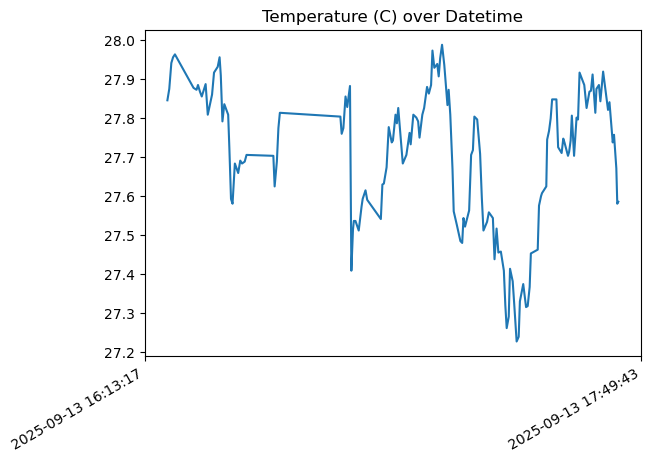

In [196]:
x = non_zero["datetime"]
y = df_barometric["temperature_c"][:158]

baro_plot(x,y,"Temperature (C) over Datetime")

## Plotting pressure

In [197]:
print(non_zero["datetime"].shape)
print(df_barometric["pressure_hpa"].shape)

(158,)
(3195,)


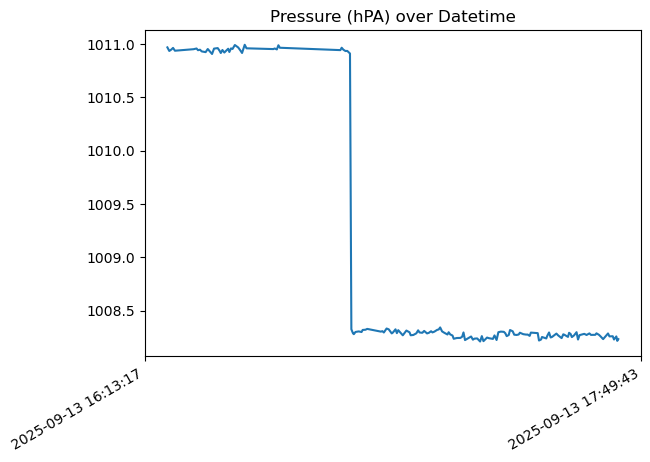

In [198]:
baro_plot(x,df_barometric["pressure_hpa"][:158],"Pressure (hPA) over Datetime")

## Plotting altitude

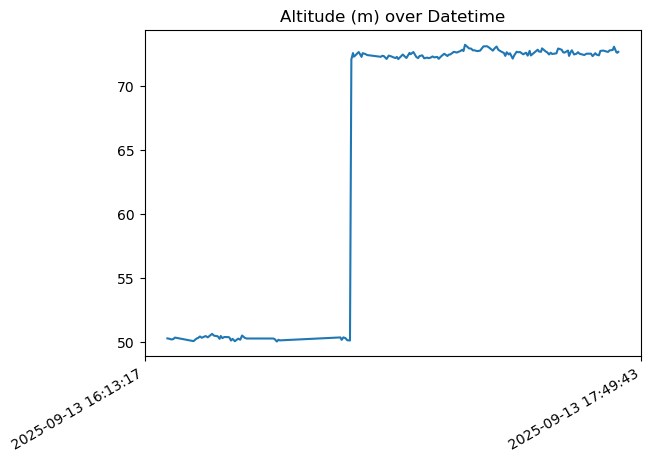

In [202]:
baro_plot(x,df_barometric["altitude_m"][:158],"Altitude (m) over Datetime")